# Boilerplate code whilst we're getting gcloud setup with data
### Subject to change

In [ ]:
import os
import sys
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Add the parent directory to the Python path
sys.path.append('..')



In [ ]:

def find_images_dir():
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    
    # List of possible directory names
    possible_names = ['mushroom_dataset', 'mushroom-dataset']
    
    # First, try to find the directory in the parent of the current directory
    for name in possible_names:
        images_dir = os.path.join(parent_dir, 'images', name)
        if os.path.exists(images_dir):
            return images_dir
    
    # If not found, try to find it in the same level as the notebooks directory
    for name in possible_names:
        images_dir = os.path.join(os.path.dirname(parent_dir), 'images', name)
        if os.path.exists(images_dir):
            return images_dir
    
    raise FileNotFoundError(f"Could not find mushroom dataset directory in {parent_dir} or {os.path.dirname(parent_dir)}")

# Function to collect dataset statistics
def collect_dataset_statistics():
    data = []
    base_path = find_images_dir()
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for type_name in os.listdir(category_path):
                type_path = os.path.join(category_path, type_name)
                if os.path.isdir(type_path):
                    for image_name in os.listdir(type_path):
                        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            data.append({
                                'file_path': os.path.join(category, type_name, image_name),
                                'category': category,
                                'type': type_name,
                                'image_name': image_name
                            })
    return pd.DataFrame(data)

# Collect dataset statistics
df = collect_dataset_statistics()

In [ ]:
df

In [ ]:
# Display dataset overview
print("Dataset Overview:")
display(df.head())

type_counts = df.groupby('category')['type'].nunique().reset_index(name='type_count')
print("\nNumber of types per category:")
display(type_counts)

image_counts = df.groupby(['category', 'type']).size().reset_index(name='image_count')
print("\nNumber of images per type:")
display(image_counts)

category_image_counts = df.groupby('category').size().reset_index(name='total_images')
print("\nTotal number of images per category:")
display(category_image_counts)

In [36]:
def display_sample_images(df, num_samples=5):
    sampled_images = df.sample(n=num_samples, random_state=42).reset_index(drop=True)
    base_path = find_images_dir()

    for index, row in sampled_images.iterrows():
        image_path = os.path.join(base_path, row['file_path'])
        image = Image.open(image_path)

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Category: {row['category']}\nType: {row['type']}")
        plt.show()



In [35]:
%matplotlib inline

sns.set(style="whitegrid")

def plot_total_images_per_category(category_image_counts):
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x='category',
        y='total_images',
        data=category_image_counts.sort_values('total_images', ascending=False),
        palette='viridis'
    )
    plt.title('Total Number of Images per Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()



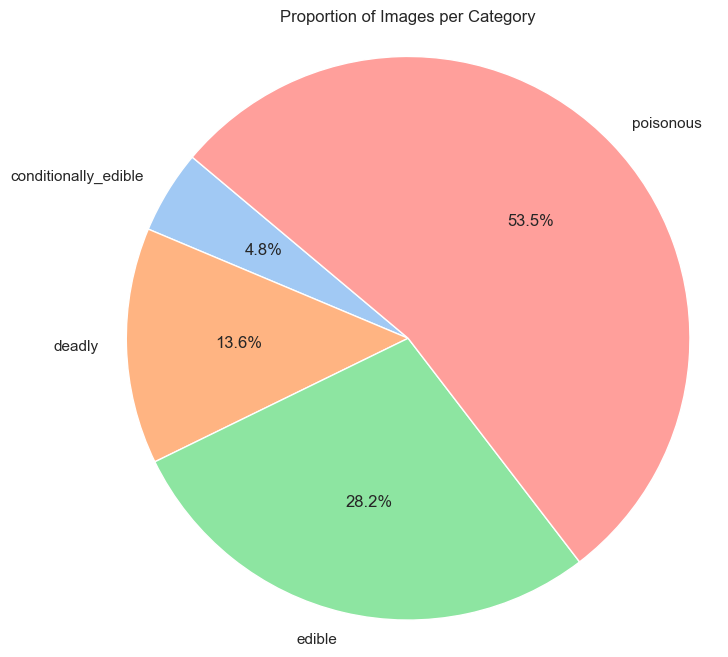

In [34]:
''' Class imbalance analysis '''
category_percentages = category_image_counts.copy()
total_images = category_percentages['total_images'].sum()
category_percentages['percentage'] = (category_percentages['total_images'] / total_images) * 100

plt.figure(figsize=(8, 8))
plt.pie(
    category_percentages['total_images'],
    labels=category_percentages['category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Proportion of Images per Category')
plt.axis('equal')
plt.show()


In [33]:
''' Plotting the distribution of images per species in each category '''

def plot_species_distribution(df):
    categories = df['category'].unique()
    for category in categories:
        category_df = df[df['category'] == category]
        species_counts = category_df.groupby('type').size().reset_index(name='image_count')
        
        plt.figure(figsize=(12, 6))
        sns.histplot(
            species_counts['image_count'],
            bins=20,
            kde=True,
            color='skyblue'
        )
        plt.title(f'Distribution of Images per Species in "{category.capitalize()}" Category')
        plt.xlabel('Number of Images per Species')
        plt.ylabel('Number of Species')
        plt.show()
        
        # Box Plot
        plt.figure(figsize=(6, 8))
        sns.boxplot(
            y=species_counts['image_count'],
            color='lightgreen'
        )
        plt.title(f'Box Plot of Images per Species in "{category.capitalize()}" Category')
        plt.ylabel('Number of Images per Species')
        plt.show()
        
        # Statistical Summary
        print(f"Statistical Summary for {category.capitalize()} Category:")
        display(species_counts['image_count'].describe())



In [23]:
def analyze_image_dimensions(df):
    widths = []
    heights = []
    aspect_ratios = []
    base_path = find_images_dir()
    
    for index, row in df.sample(n=500, random_state=42).iterrows():
        image_path = os.path.join(base_path, row['file_path'])
        img = Image.open(image_path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(width / height)
    
    df_dimensions = pd.DataFrame({
        'width': widths,
        'height': heights,
        'aspect_ratio': aspect_ratios
    })
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='width', y='height', data=df_dimensions, alpha=0.5)
    plt.title('Image Width vs. Height')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sns.histplot(df_dimensions['aspect_ratio'], bins=30, kde=True, color='coral')
    plt.title('Distribution of Image Aspect Ratios')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Number of Images')
    plt.show()
    
    print("Statistical Summary of Image Dimensions:")
    display(df_dimensions.describe())


In [30]:
def analyze_color_distribution(df):
    avg_colors = []
    labels = []
    base_path = find_images_dir()
    
    for index, row in df.sample(n=500, random_state=42).iterrows():
        image_path = os.path.join(base_path, row['file_path'])
        img = Image.open(image_path).resize((50, 50))
        img_array = np.array(img)
        avg_color = img_array.mean(axis=(0, 1))  # Average over width and height
        avg_colors.append(avg_color)
        labels.append(row['category'])
    
    avg_colors = np.array(avg_colors)
    
    color_df = pd.DataFrame({
        'R': avg_colors[:, 0],
        'G': avg_colors[:, 1],
        'B': avg_colors[:, 2],
        'category': labels
    })
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='R', data=color_df)
    plt.title('Distribution of Average Red Channel by Category')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='G', data=color_df)
    plt.title('Distribution of Average Green Channel by Category')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='B', data=color_df)
    plt.title('Distribution of Average Blue Channel by Category')
    plt.show()


Dataset Overview:


,file_path,category,type,image_name
0,conditionally_edible/Amanita_fulva/Amanita_ful...,conditionally_edible,Amanita_fulva,Amanita_fulva49.png
1,conditionally_edible/Amanita_fulva/Amanita_ful...,conditionally_edible,Amanita_fulva,Amanita_fulva48.png
2,conditionally_edible/Amanita_fulva/Amanita_ful...,conditionally_edible,Amanita_fulva,Amanita_fulva10.png
3,conditionally_edible/Amanita_fulva/Amanita_ful...,conditionally_edible,Amanita_fulva,Amanita_fulva38.png
4,conditionally_edible/Amanita_fulva/Amanita_ful...,conditionally_edible,Amanita_fulva,Amanita_fulva39.png



Number of types per category:


,category,type_count
0,conditionally_edible,8
1,deadly,40
2,edible,67
3,poisonous,146



Number of images per type:


,category,type,image_count
0,conditionally_edible,Amanita_fulva,51
1,conditionally_edible,Amanita_muscaria,51
2,conditionally_edible,Amanita_rubescens,58
3,conditionally_edible,Coprinopsis_atramentaria,56
4,conditionally_edible,Gyromitra_esculenta,44
...,...,...,...
256,poisonous,Tricholoma_pardinum,31
257,poisonous,Tricholoma_sulphureum,20
258,poisonous,Trogia_venenata,28
259,poisonous,Turbinellus_floccosus,31



Total number of images per category:


,category,total_images
0,conditionally_edible,420
1,deadly,1190
2,edible,2475
3,poisonous,4696



Sample Images:


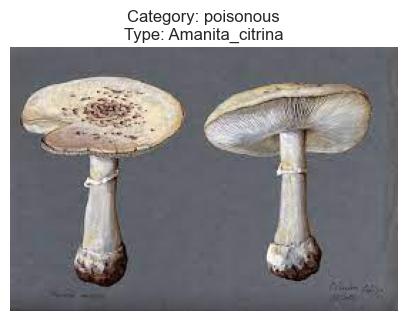

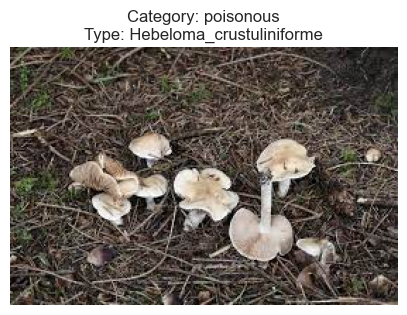

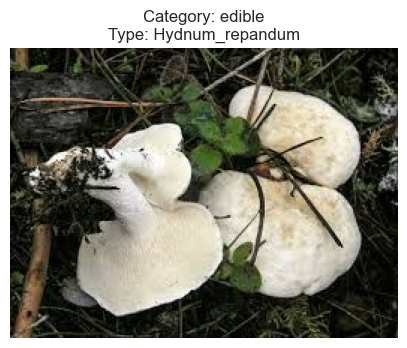

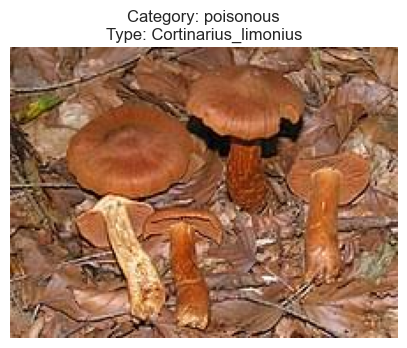

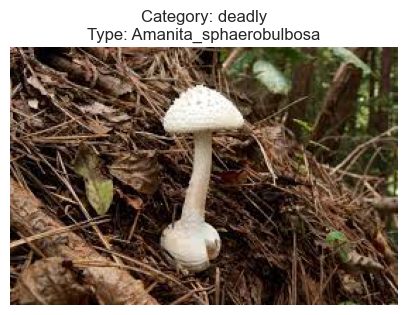

In [32]:
# Main execution
df = collect_dataset_statistics()
print("Dataset Overview:")
display(df.head())

type_counts = df.groupby('category')['type'].nunique().reset_index(name='type_count')
print("\nNumber of types per category:")
display(type_counts)

image_counts = df.groupby(['category', 'type']).size().reset_index(name='image_count')
print("\nNumber of images per type:")
display(image_counts)

category_image_counts = df.groupby('category').size().reset_index(name='total_images')
print("\nTotal number of images per category:")
display(category_image_counts)

print("\nSample Images:")
display_sample_images(df, num_samples=5)



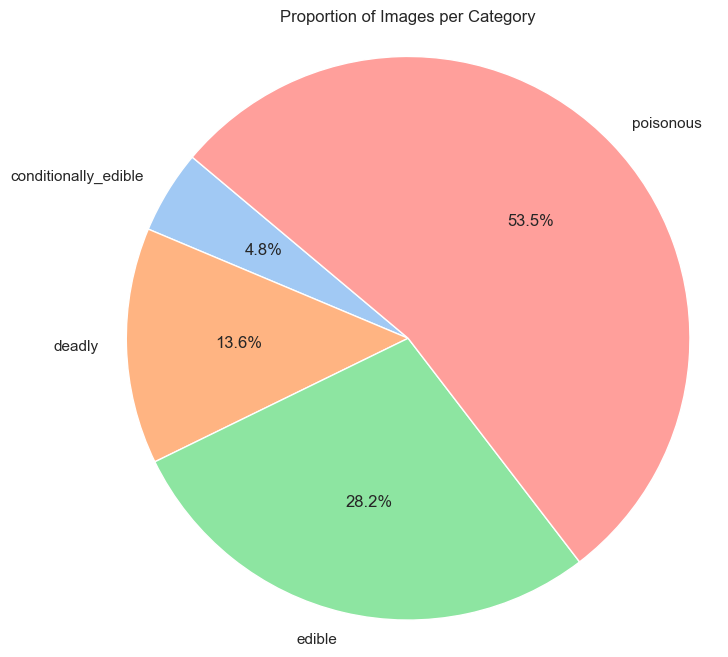

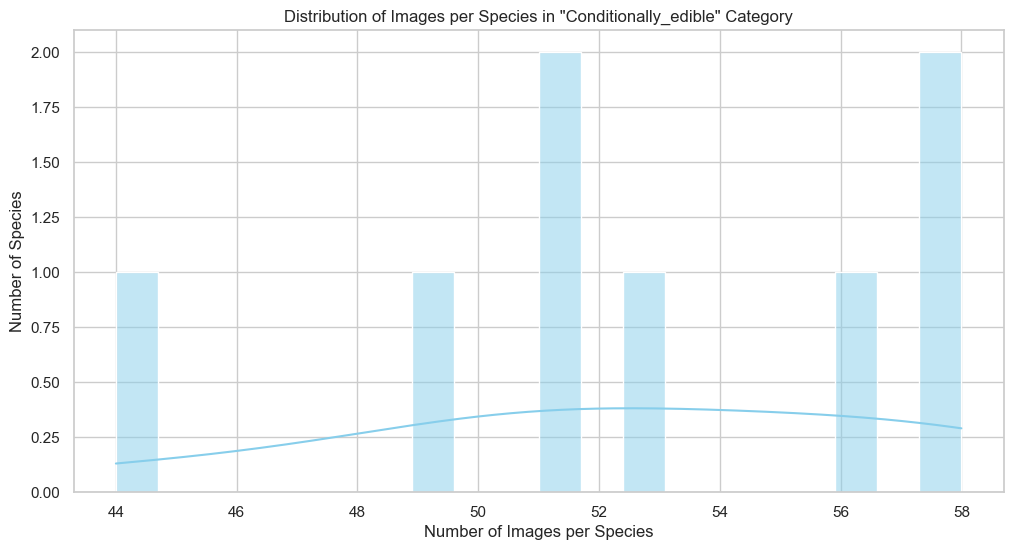

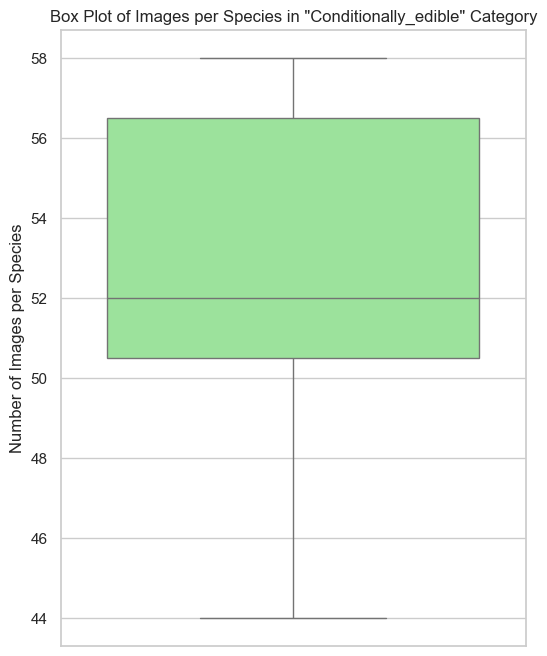

Statistical Summary for Conditionally_edible Category:


count     8.000000
mean     52.500000
std       4.810702
min      44.000000
25%      50.500000
50%      52.000000
75%      56.500000
max      58.000000
Name: image_count, dtype: float64

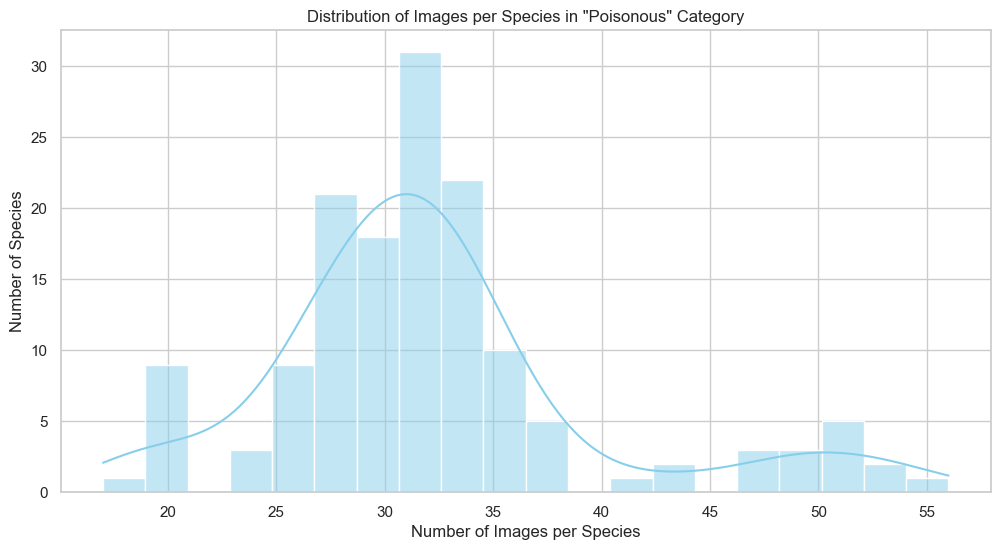

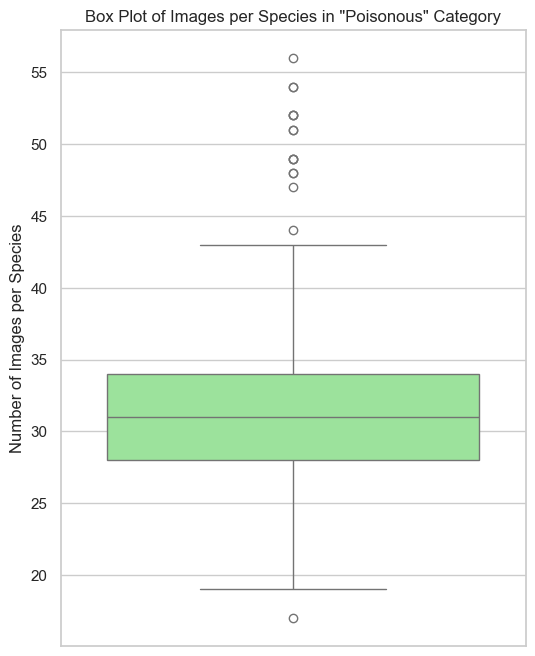

Statistical Summary for Poisonous Category:


count    146.000000
mean      32.164384
std        7.673535
min       17.000000
25%       28.000000
50%       31.000000
75%       34.000000
max       56.000000
Name: image_count, dtype: float64

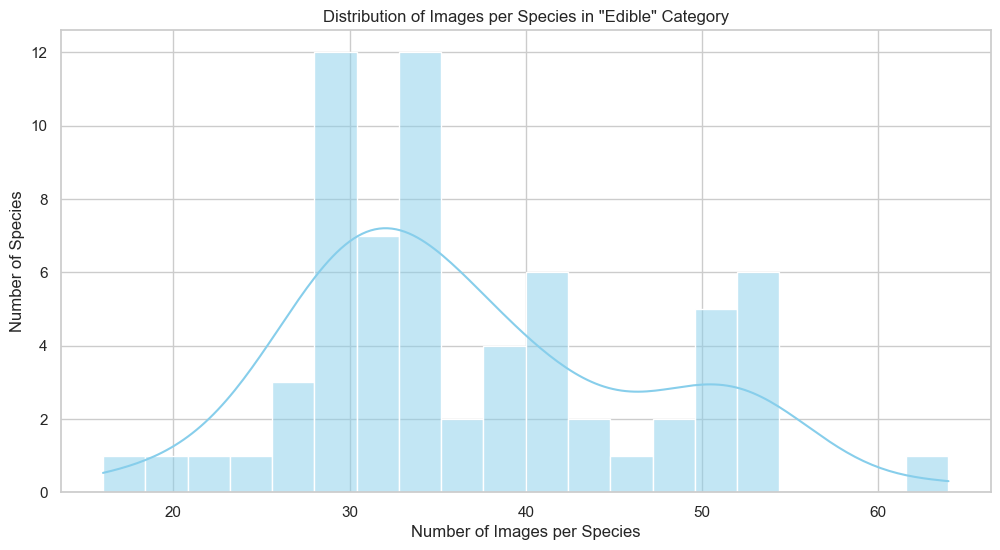

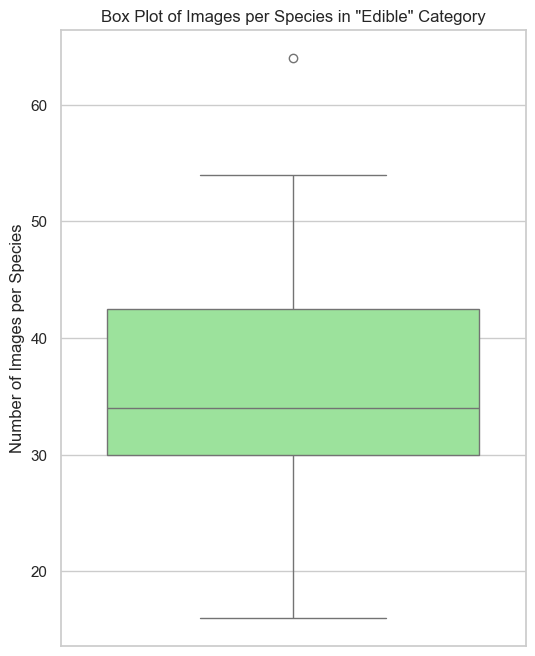

Statistical Summary for Edible Category:


count    67.000000
mean     36.940299
std       9.816314
min      16.000000
25%      30.000000
50%      34.000000
75%      42.500000
max      64.000000
Name: image_count, dtype: float64

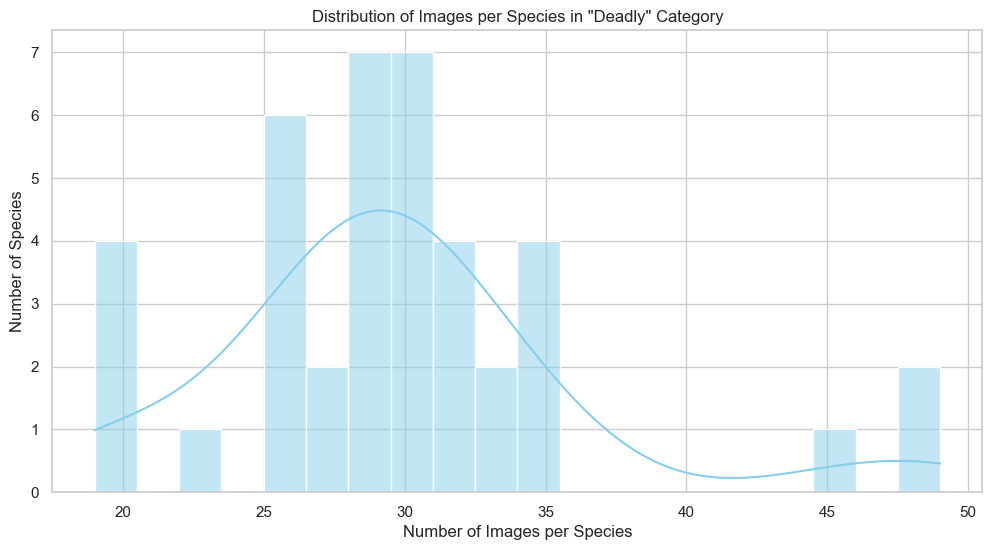

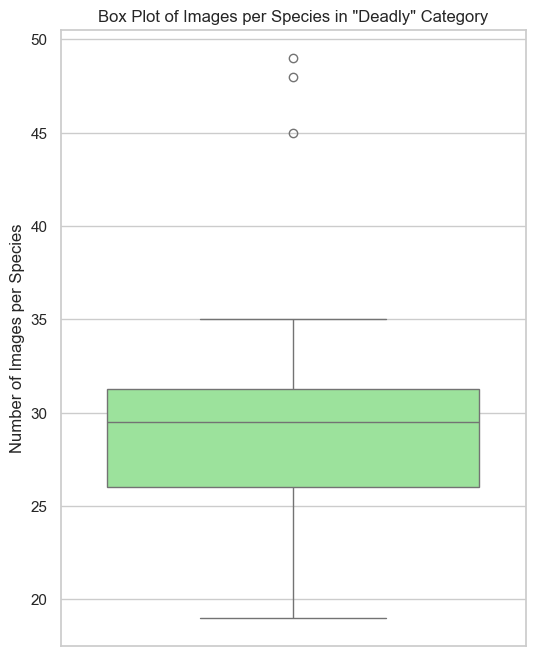

Statistical Summary for Deadly Category:


count    40.000000
mean     29.750000
std       6.534916
min      19.000000
25%      26.000000
50%      29.500000
75%      31.250000
max      49.000000
Name: image_count, dtype: float64

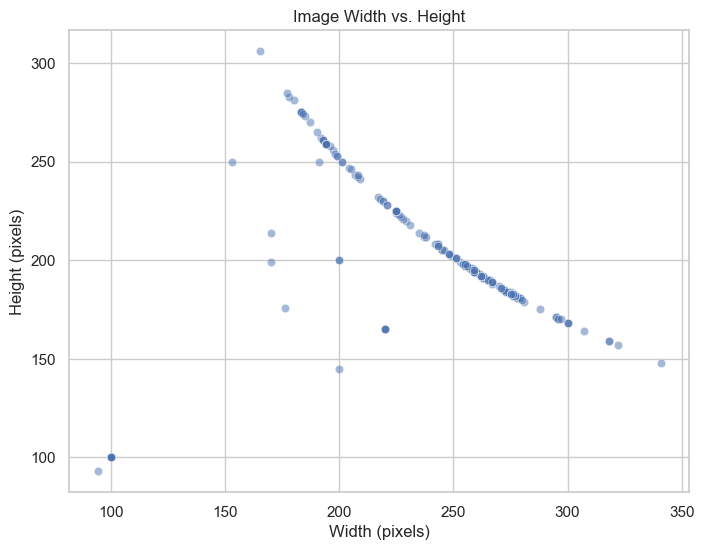

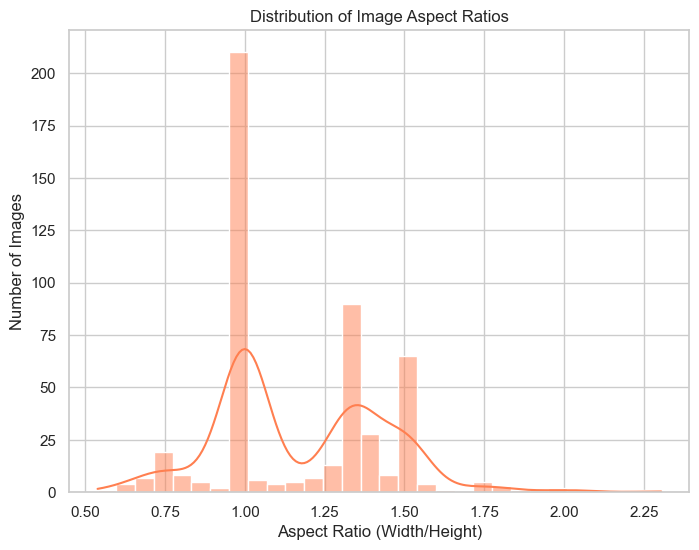

Statistical Summary of Image Dimensions:


,width,height,aspect_ratio
count,500.0000,500.000000,500.000000
mean,193.6900,163.318000,1.173130
std,77.1634,53.987537,0.261325
min,94.0000,93.000000,0.539216
25%,100.0000,100.000000,1.000000
50%,225.0000,183.000000,1.000000
75%,260.0000,194.000000,1.340206
max,341.0000,306.000000,2.304054


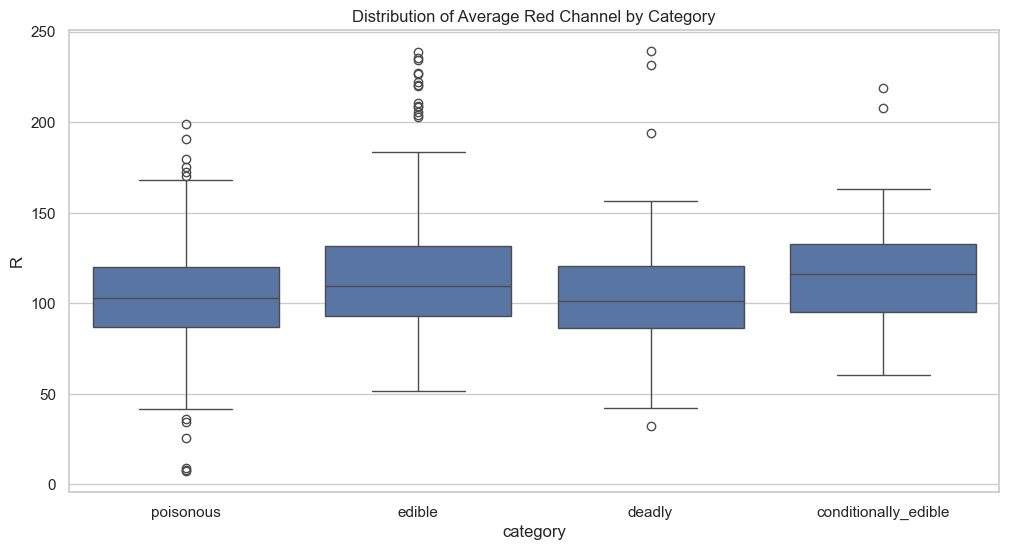

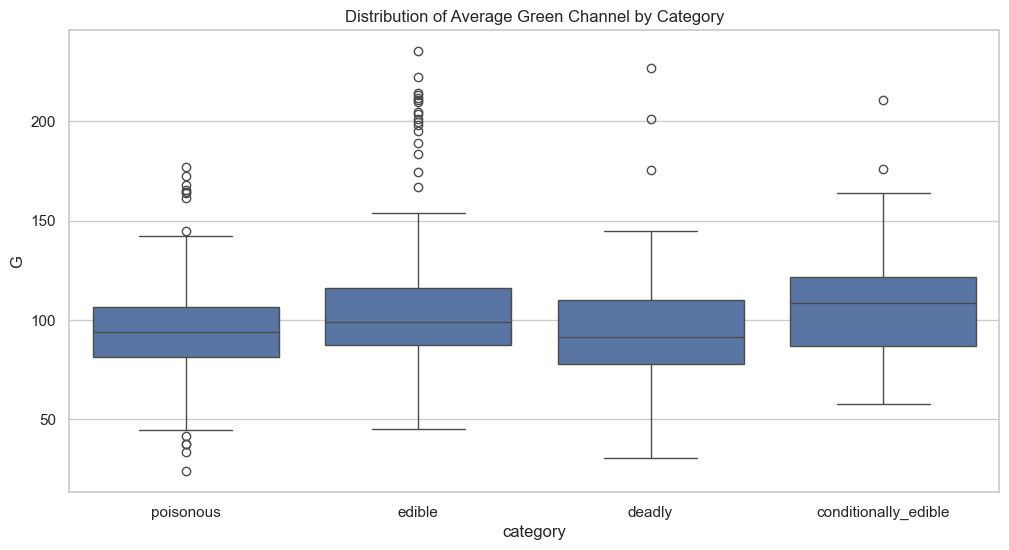

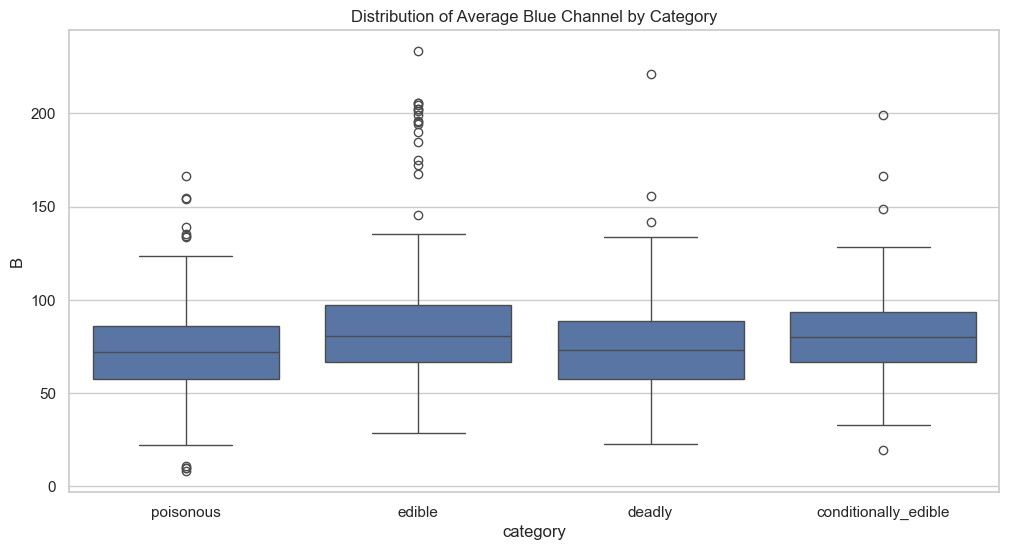

In [29]:
# Class imbalance analysis
category_percentages = category_image_counts.copy()
total_images = category_percentages['total_images'].sum()
category_percentages['percentage'] = (category_percentages['total_images'] / total_images) * 100

plt.figure(figsize=(8, 8))
plt.pie(
    category_percentages['total_images'],
    labels=category_percentages['category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Proportion of Images per Category')
plt.axis('equal')
plt.show()

plot_species_distribution(df)
analyze_image_dimensions(df)
analyze_color_distribution(df)